# RBIG Demo

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import corner

In [3]:
ntrain = 100_000
ntest = 10_000
nplot = 1_000_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]
plot_data = make_moons(n_samples=nplot, noise=noise, random_state=random_state*10)[0]

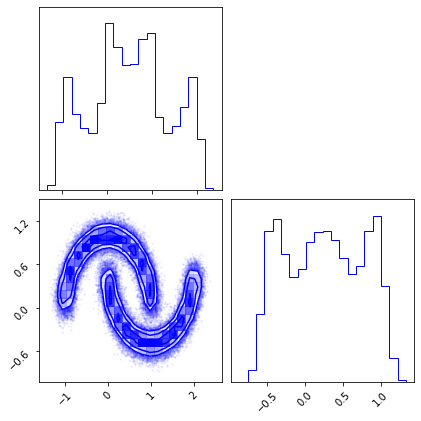

In [4]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

In [6]:
from rbig._src.uniform import MarginalHistogramUniformization
from rbig._src.invcdf import InverseGaussCDF
from rbig._src.rotation import PCARotation
from rbig._src.losses import negative_log_likelihood
from rbig._src.total_corr import information_reduction
from rbig._src.training import train_rbig_info_loss
from rbig._src.model import RBIG
from tqdm.notebook import trange
import numpy as np

In [8]:
train_data.shape

(100000, 2)

In [9]:
gf_model = RBIG()
gf_model.fit(train_data)

Completed! (Total Info Red: 1.2309):  13%|█▎        | 132/1000 [00:09<01:00, 14.32it/s]


RBIG()

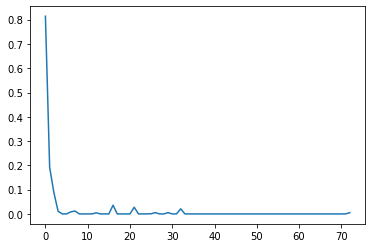

In [10]:
plt.plot(gf_model.info_loss)

## Latent Space

In [11]:
Xg = gf_model.transform(train_data)

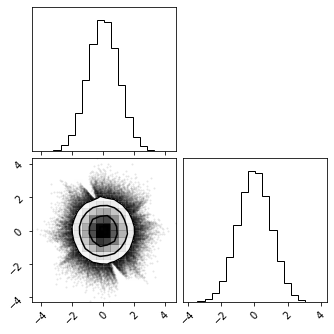

In [12]:
fig = corner.corner(Xg)

## Density Estimation

In [13]:
n_grid = 500
buffer = 0.01
xline = np.linspace(test_data[:, 0].min() - buffer, train_data[:, 0].max() + buffer, n_grid)
yline = np.linspace(test_data[:, 1].min() - buffer, train_data[:, 1].max() + buffer, n_grid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [14]:
X_prob = gf_model.predict_proba(xyinput)

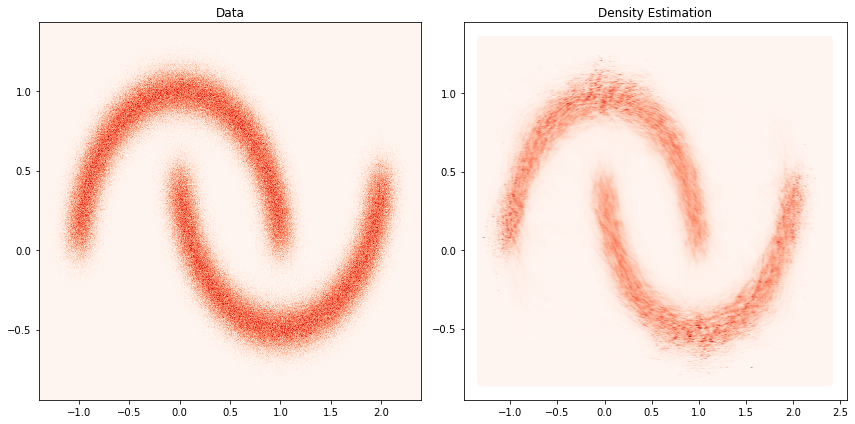

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('Data')
ax[0].hist2d(plot_data[...,0], plot_data[...,1], cmap="Reds", bins=512, density=True)
# ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Density Estimation')
ax[1].scatter(xyinput[...,0], xyinput[...,1], c=X_prob, cmap="Reds", vmax=1.9)
# ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

## Samples


In [16]:
X_samples = gf_model.sample(10_000)

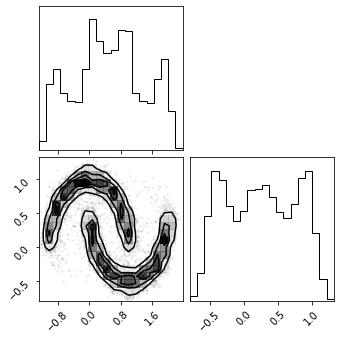

In [17]:
fig = corner.corner(X_samples)

## Information Theoretic Measures

### Total Correlation

In [18]:
gf_model.total_correlation()


1.2309280975134382e+00